In [6]:
import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import  math
#import matplotlib as plt

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Start with sample with secondary porosity

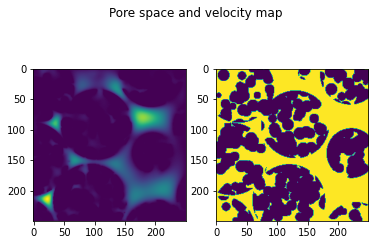

In [7]:

slice = 49

secondaryImage = np.transpose(secondaryImage)
primaryImage = np.transpose(primaryImage)

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

Now plot the sample with just primary porosity

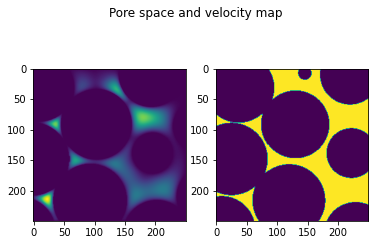

In [8]:
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])



Now compare the pore space of both samples

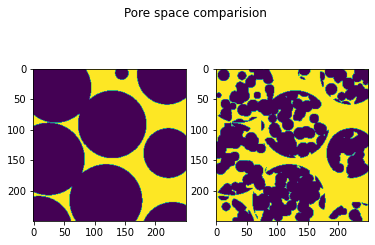

In [9]:
slice = 49

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space comparision')
p1.imshow(primaryImage[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

# Extract pore network information

In [10]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1436
Peaks after trimming saddle points:  938
Peaks after trimming nearby peaks:  922
------------------------------------------------------------
Extracting pore and throat information from image
100%|████████████████████████████████████████████████████████████████████████████████| 922/922 [00:09<00:00, 96.05it/s]


In [11]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)




------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:05<00:00, 18.50it/s]


Assign simulated velocities to an identified pore region

In [18]:
cubeSize = len(secondaryImage)
velocitiesSecondary = {}
regionMapSecondary = snowFiltSecondary.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMapSecondary[a,b,c])
            if key != '0.0':
                if key in velocitiesSecondary:
                    velocitiesSecondary[key].append(velDataNormSecondary[a,b,c])
                else:
                    velocitiesSecondary.setdefault(key,[])
                    velocitiesSecondary[key].append(velDataNormSecondary[a,b,c])

In [14]:
cubeSize = len(primaryImage)
velocitiesPrimary= {}
regionMapPrimary = snowFiltPrimary.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMapPrimary[a,b,c])
            if key != '0.0':
                if key in velocitiesPrimary:
                    velocitiesPrimary[key].append(velDataNormPrimary[a,b,c])
                else:
                    velocitiesPrimary.setdefault(key,[])
                    velocitiesPrimary[key].append(velDataNormPrimary[a,b,c])

# Prepare the pore space and velocity data for plotting

Take the median velocity of each pore for plotting

In [16]:
nRegions = np.unique(snowFiltPrimary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)
primaryMedianVelNormPoreVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]
    primaryMedianVelNormPoreVec[a] = np.median(velocitiesPrimary.get(str(a)))


In [19]:
nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVecSecondary = np.zeros(nRegions,)
secondaryMedianVelNormPoreVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVecSecondary[a] = poreInfoSecondary['pore.diameter'][a]
    secondaryMedianVelNormPoreVec[a] = np.median(velocitiesSecondary.get(str(a)))

# Plot the distribution of an estimate of pore velocity

Text(0.5, 0, 'Median simulated pore velocity per region')

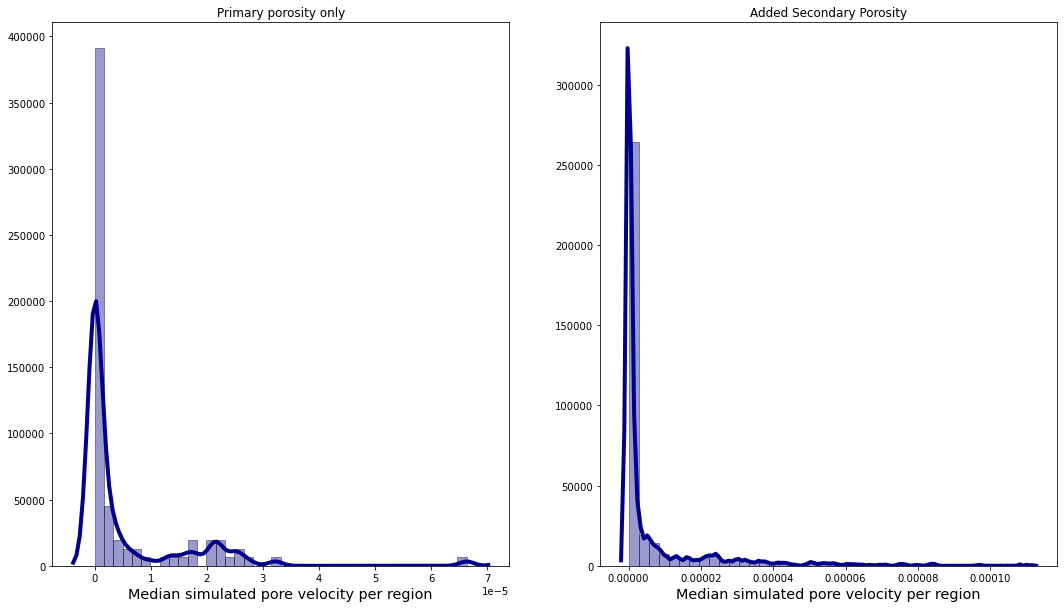

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.distplot(primaryMedianVelNormPoreVec, ax=axes[0], hist=True, kde=True,
             bins=int(40), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Median simulated pore velocity per region',fontsize='x-large')

sns.distplot(secondaryMedianVelNormPoreVec, ax=axes[1], hist=True, kde=True,
             bins=int(40), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Added Secondary Porosity')
axes[1].set_xlabel('Median simulated pore velocity per region',fontsize='x-large')


